## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the dataset
retail_df = pd.read_csv("Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail_df.shape

(541909, 8)

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the data

In [5]:
# Lets check for the nulll values.
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# let's check what is the prapotion of the missing values.
round(((retail_df.isnull().sum())/len(retail_df))*100, 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

- There are two columns Description and CustomerID column available which have 0.27% and 25% null values.
- So we are going to drop these values as we don't have any information about Customers which have null values as CustomerID.

In [7]:
retail_df = retail_df.dropna()

In [8]:
# let's check what is the prapotion of the missing values.
round(((retail_df.isnull().sum())/len(retail_df))*100, 2)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [9]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


- Now After null value treatment we have 406829 rows and 8 columns available in our data.

# 3. Prepare the data for modelling
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)
- Here we have to drive some new features from the priviously available columns.

In [10]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


#### M (Monetary): Total amount of transactions (revenue contributed)
- Here we compute the total amount parches by the customer.
- First we have to create a amount feature by multiplying Quantity and UnitPrice value.
- Then we groupby the data using CustomerID and compute the total amount by every customer.

In [11]:
retail_df['amount'] = retail_df['UnitPrice']*retail_df['Quantity']

In [12]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [13]:
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()

In [14]:
grouped_df

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


#### F (Frequency): Number of tracsactions
- Here we drive a new features by Frequency Using CustomerID and InvoiceNo.

In [15]:
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()

In [16]:
frequency

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [17]:
# merge the both dataframmes
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df

,CustomerID,amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17
...,...,...,...
4367,18280.0,180.60,10
4368,18281.0,80.82,7
4369,18282.0,176.60,13
4370,18283.0,2094.88,756


#### R (Recency): Number of days since last purchase
- Here we are finding that how recent has every customer done a transaction from the last transaction.
- For this we first have to convert the InvoiceDate column into the datetime format.
- Then we find out the last transaction date and compute the difference of all the InvoiceDate for all the CustomerID.
- Lastly we groupby the df on CustomerID and then compute the minimum diff of trancsaction.

In [18]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [19]:
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [20]:
maxDate = max(retail_df['InvoiceDate'])

In [21]:
retail_df['diff'] = maxDate - retail_df['InvoiceDate']

In [22]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [23]:
recency = retail_df.groupby('CustomerID')['diff'].min()

In [24]:
recency = recency.reset_index()

In [25]:
recency

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00
...,...,...
4367,18280.0,277 days 02:58:00
4368,18281.0,180 days 01:57:00
4369,18282.0,7 days 01:07:00
4370,18283.0,3 days 00:48:00


In [26]:
# merge the both dataframmes
grouped_df = pd.merge(grouped_df, recency, on='CustomerID', how='inner')
grouped_df.columns

Index(['CustomerID', 'amount', 'InvoiceNo', 'diff'], dtype='object')

In [27]:
grouped_df = grouped_df.rename(columns = {'InvoiceNo' : 'frequency', 'diff' : 'recency'})

In [28]:
grouped_df

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00
...,...,...,...,...
4367,18280.0,180.60,10,277 days 02:58:00
4368,18281.0,80.82,7,180 days 01:57:00
4369,18282.0,176.60,13,7 days 01:07:00
4370,18283.0,2094.88,756,3 days 00:48:00


In [29]:
grouped_df['recency'] = grouped_df['recency'].dt.days 

In [30]:
grouped_df

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
...,...,...,...,...
4367,18280.0,180.60,10,277
4368,18281.0,80.82,7,180
4369,18282.0,176.60,13,7
4370,18283.0,2094.88,756,3


{'whiskers': [<matplotlib.lines.Line2D at 0x2374a922340>,
 'caps': [<matplotlib.lines.Line2D at 0x2374a9228e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2374a909eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x2374a922e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x2374a91a190>],
 'means': []}

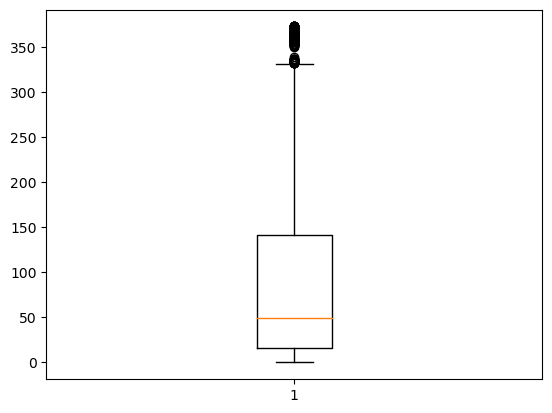

In [31]:
# 1. outlier treatment
plt.boxplot(grouped_df['recency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2374c42f490>,
 'caps': [<matplotlib.lines.Line2D at 0x2374c42fa30>,
 'boxes': [<matplotlib.lines.Line2D at 0x2374c42f220>],
 'medians': [<matplotlib.lines.Line2D at 0x2374c42ffd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2374c43d2e0>],
 'means': []}

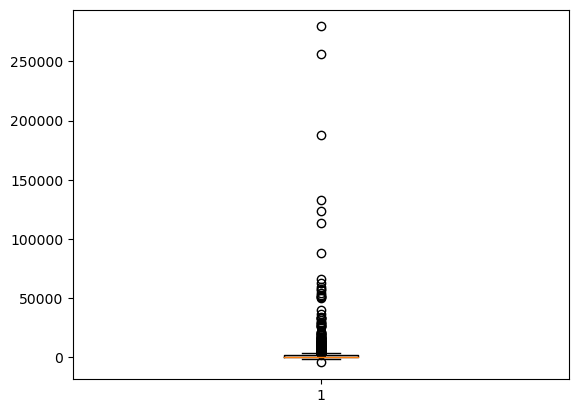

In [32]:
plt.boxplot(grouped_df['amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2374c450d90>,
 'caps': [<matplotlib.lines.Line2D at 0x2374c460370>,
 'boxes': [<matplotlib.lines.Line2D at 0x2374c450ac0>],
 'medians': [<matplotlib.lines.Line2D at 0x2374c460910>],
 'fliers': [<matplotlib.lines.Line2D at 0x2374c460be0>],
 'means': []}

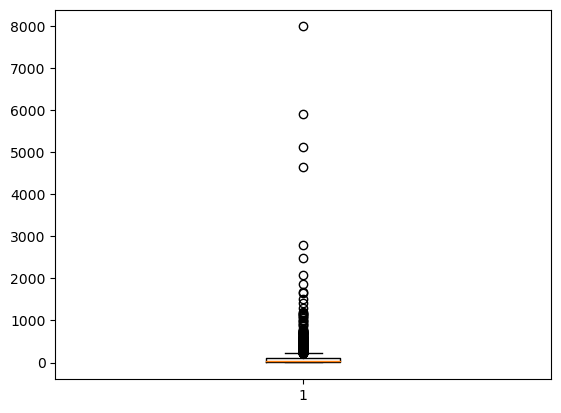

In [33]:
plt.boxplot(grouped_df['frequency'])

In [34]:
# two types of outliers:
# - statistical
# - domain specific

In [35]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [36]:
grouped_df

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
...,...,...,...,...
4366,18278.0,173.90,9,73
4367,18280.0,180.60,10,277
4368,18281.0,80.82,7,180
4369,18282.0,176.60,13,7


In [37]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

In [38]:
rfm_df

,amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309
...,...,...,...
4366,173.90,9,73
4367,180.60,10,277
4368,80.82,7,180
4369,176.60,13,7


In [39]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(rfm_df)

In [40]:
rfm_df = pd.DataFrame(scaled_df)
rfm_df.columns = ['amount', 'frequency', 'recency']

# 4. Modelling

In [41]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df)

KMeans(max_iter=50, n_clusters=4)

In [42]:
kmeans.labels_

array([1, 3, 2, ..., 1, 2, 2])

In [43]:
kmeans.inertia_

3360.7295976449363

## Finding the Optimal Number of Clusters

### SSD

In [44]:
ssd = []
n_clusters = [2, 3, 4, 5, 6, 7, 8]
for clusters in n_clusters:
    kmeans = KMeans(n_clusters=clusters, max_iter=50)
    kmeans.fit(rfm_df)
    ssd.append(kmeans.inertia_)
    

In [47]:
ssd

[7661.705869320753,
 4433.580619302121,
 3360.540096249711,
 2802.9264185584857,
 2391.983764995046,
 2039.2745592166289,
 1825.603488162297]

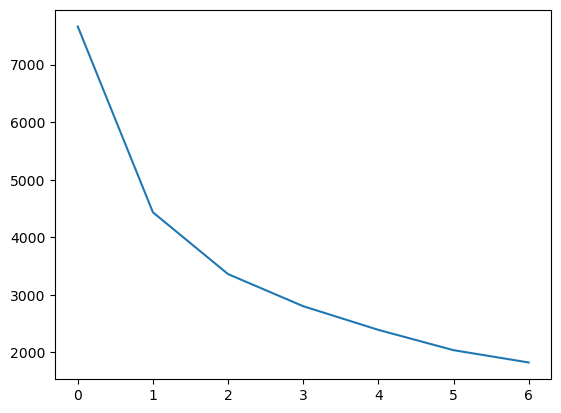

In [46]:
plt.plot(ssd)